In [84]:
import sqlite3
import pandas as pd
import struct
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import joblib

### Vectorización de audio features

In [2]:
def load_data():
    """ Lee features de la base de datos features.db"""

    features_db_path = "dataset/features.db"
    genres_db_path = "dataset/genres.db"
    metadata_db_path = "dataset/metadata.db"
    tags_db_path = "dataset/tags.db"

    conn = sqlite3.connect(features_db_path)
    features_df = pd.read_sql_query("SELECT * FROM features", conn)
    conn.close()

    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    if not os.path.exists("models"):
        os.makedirs("models")

    return features_df, genres_df, metadata_df, tags_df

features_df, genres_df, metadata_df, tags_df = load_data()

In [3]:
def decode_tempo(b):
    try:
        if isinstance(b, float):
            return b
        if isinstance(b, (bytes, bytearray)) and len(b) == 4:
            return struct.unpack('f', b)[0]  # <-- 'f' = float32 (4 bytes)
        if isinstance(b, str) and ',' in b:
            byte_list = list(map(int, b.split(',')))
            b = bytes(byte_list)
            return struct.unpack('f', b)[0]
    except Exception as e:
        print(f"⚠️ decode_tempo falló con {repr(b)}: {e}")
    return np.nan

def decode_array(b):
    try: 
        return np.frombuffer(b, dtype=np.float32)
    except Exception:
        return b

def concat_full_vector():
    """Concatena en un solo vector datos de features, genres y tags"""
    df = pd.concat([features_df, genres_df, tags_df], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True)
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        row_copy = row.drop(labels=['mfcc_mean', 'tempo', 'stft_mean', 'chroma_mean'], errors = "ignore").copy()
        other_features = row_copy.values.astype(np.float32)
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo, other_features])
        vectors.append(full_vector)
    return np.stack(vectors)

def concat_vector():
    """"Concatena en un solo vector datos de features solo"""
    df = features_df.copy()
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True) 
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo])
        vectors.append(full_vector)
    return np.stack(vectors)

vectors = concat_vector()
full_vectors = concat_full_vector()
print(vectors.shape)
print(vectors[0].shape)
print(full_vectors.shape)
print(full_vectors[0].shape)

(17783, 1051)
(1051,)
(17783, 1146)
(1146,)


### Normalización

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(vectors)
X_full = scaler.fit_transform(full_vectors)

In [5]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_full_train, X_full_test = train_test_split(X_full, test_size=0.2, random_state=42)

### Análisis de componentes principales (PCA)

In [80]:
pca = PCA(n_components = 128)
X_pca = pca.fit(X_train)

X_pca_test = pca.transform(X_test)
explained_var_ratio = pca.explained_variance_ratio_
cumulative_variance  = np.cumsum(explained_var_ratio)

print(f"Varianza explicada total (128D): {cumulative_variance[-1]*100:.2f}%")
print("Primeras 10 componentes (varianza explicada):")
print(np.round(explained_var_ratio[:10] * 100, 2)) 

X_reconstructed = pca.inverse_transform(X_pca_test)
mse_reconstruction = np.mean(np.power(X_test - X_reconstructed, 2))
mae_reconstruction = np.mean(np.abs(X_test - X_reconstructed))
rmse_reconstruction = np.sqrt(mse_reconstruction)

print(f"MSE de reconstrucción: {mse_reconstruction:.4f}")
print(f"MAE de reconstrucción: {mae_reconstruction:.4f}")
print(f"RMSE de reconstrucción: {rmse_reconstruction:.4f}")


Varianza explicada total (128D): 92.70%
Primeras 10 componentes (varianza explicada):
[43.37  7.98  5.31  3.    1.88  1.5   1.28  1.08  0.98  0.92]
MSE de reconstrucción: 0.0850
MAE de reconstrucción: 0.1146
RMSE de reconstrucción: 0.2916


In [81]:
pca_full = PCA(n_components = 128)
X_pca = pca_full.fit(X_full_train)

X_pca_test = pca_full.transform(X_full_test)
explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_variance_full  = np.cumsum(explained_var_ratio)

print(f"Varianza explicada total (128D): {cumulative_variance_full[-1]*100:.2f}%")
print("Primeras 10 componentes (varianza explicada):")
print(np.round(explained_var_ratio[:10] * 100, 2)) 

X_reconstructed = pca_full.inverse_transform(X_pca_test)
mse_reconstruction = np.mean(np.power(X_full_test - X_reconstructed, 2))
mae_reconstruction = np.mean(np.abs(X_full_test - X_reconstructed))
rmse_reconstruction = np.sqrt(mse_reconstruction)

print(f"MSE de reconstrucción: {mse_reconstruction:.4f} ")
print(f"RMSE de reconstrucción: {rmse_reconstruction:.4f}")
print(f"MAE de reconstrucción: {mae_reconstruction:.4f}")

Varianza explicada total (128D): 86.74%
Primeras 10 componentes (varianza explicada):
[39.93  7.36  4.9   2.78  1.76  1.39  1.18  0.99  0.9   0.85]
MSE de reconstrucción: 0.1508 
RMSE de reconstrucción: 0.3883
MAE de reconstrucción: 0.1556


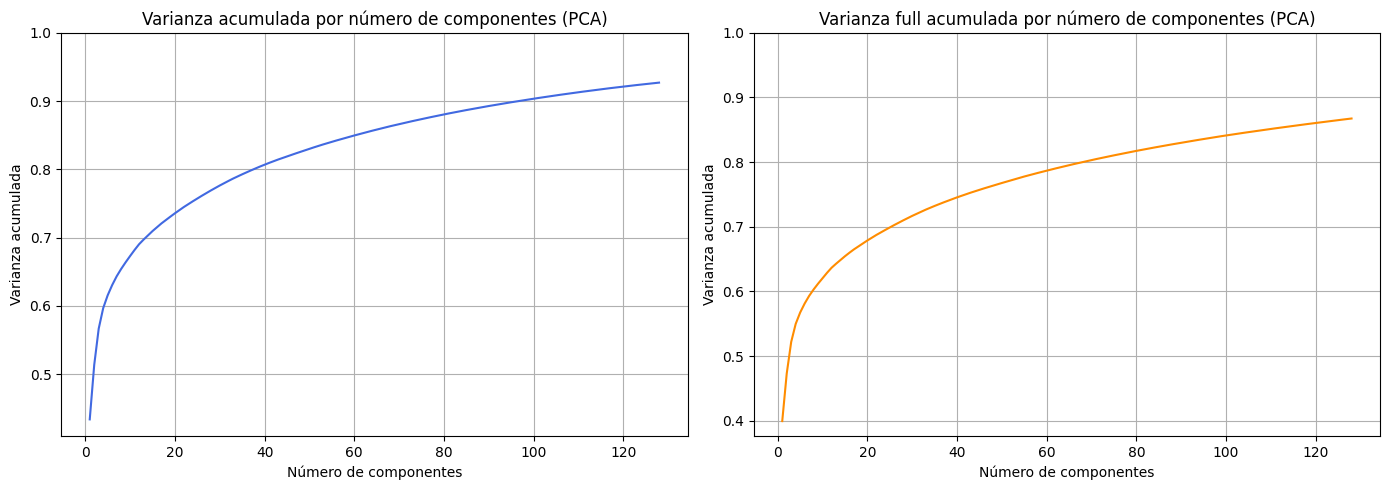

In [82]:
plt.figure(figsize=(14, 5))

# Subplot 1: Varianza acumulada (normal)
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 129), cumulative_variance[:128], color='royalblue')
plt.title("Varianza acumulada por número de componentes (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(top=1)
plt.grid(True)

# Subplot 2: Varianza acumulada (full)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 129), cumulative_variance_full[:128], color='darkorange')
plt.title("Varianza full acumulada por número de componentes (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(top=1)
plt.grid(True)

plt.tight_layout()
plt.show()

### Autoencoders

#### Autoencoder simple (AE)

In [6]:
def build_autoencoder(input_dim, latent_dim):
    """Construye un autoencoder simple"""
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    decoded = Dense(512, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

In [ ]:
autoencoder, encoder = build_autoencoder(input_dim=X.shape[1], latent_dim=128)
print(encoder.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       538,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,288 (2.31 MB)

 Trainable params: 604,288 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [8]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6314 - val_loss: 0.3820
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3601 - val_loss: 0.3070
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3110 - val_loss: 0.2578
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2456 - val_loss: 0.2396
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2159 - val_loss: 0.2365
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2094 - val_loss: 0.2063
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1940 - val_loss: 0.1962
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1757 - val_loss: 0.1893
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1734 - val_loss: 0.1847
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1581 - val_loss: 0.1744
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1504 - val_loss: 0.1677
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1506 -

In [9]:
autoencoder_full, encoder_full = build_autoencoder(input_dim=X_full.shape[1], latent_dim=128)
autoencoder_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6618 - val_loss: 0.4345
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4127 - val_loss: 0.3724
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3521 - val_loss: 0.3144
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3029 - val_loss: 0.2940
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2747 - val_loss: 0.2650
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2537 - val_loss: 0.2588
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2340 - val_loss: 0.2421
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2208 - val_loss: 0.2292
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2098 - val_loss: 0.2160
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1939 - val_loss: 0.2170
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1929 - val_loss: 0.2092
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1

In [11]:
# Evaluación de los autoencoders
decoded_vectors = autoencoder.predict(X_test)
decoded_full_vectors = autoencoder_full.predict(X_full_test)
# MSE
mse_vectors = np.mean(np.power(X_test - decoded_vectors, 2), axis=1)
mse_full_vectors = np.mean(np.power(X_full_test - decoded_full_vectors, 2), axis=1)
# MAE
mae_vectors = np.mean(np.abs(X_test - decoded_vectors), axis=1)
mae_full_vectors = np.mean(np.abs(X_full_test - decoded_full_vectors), axis=1)
# RMSE
rmse_vectors = np.sqrt(mse_vectors)
rmse_full_vectors = np.sqrt(mse_full_vectors)
print(f"MSE: {mse_vectors.mean()} ± {mse_vectors.std()}")
print(f"RMSE: {rmse_vectors.mean()} ± {rmse_vectors.std()}")
print(f"MAE: {mae_vectors.mean()} ± {mae_vectors.std()} \n")

print(f"MSE full: {mse_full_vectors.mean()} ± {mse_full_vectors.std()}")
print(f"RMSE full: {rmse_full_vectors.mean()} ± {rmse_full_vectors.std()}")
print(f"MAE full: {mae_full_vectors.mean()} ± {mae_full_vectors.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.10217239707708359 ± 0.49781283736228943
RMSE: 0.22905953228473663 ± 0.2229442298412323
MAE: 0.15325257182121277 ± 0.14424175024032593 

MSE full: 0.1295306533575058 ± 0.5994991660118103
RMSE full: 0.27780434489250183 ± 0.228813037276268
MAE full: 0.17712070047855377 ± 0.1457168161869049


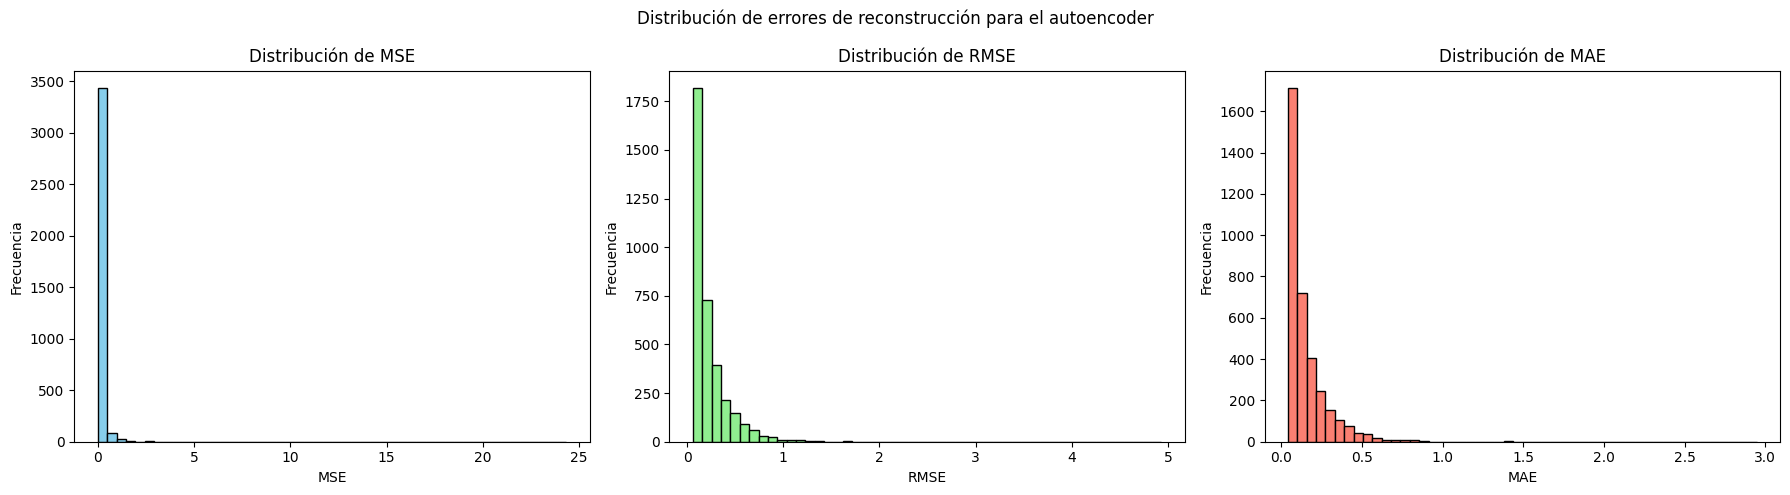

In [35]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el autoencoder')
plt.subplot(1, 3, 1)
plt.hist(mse_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

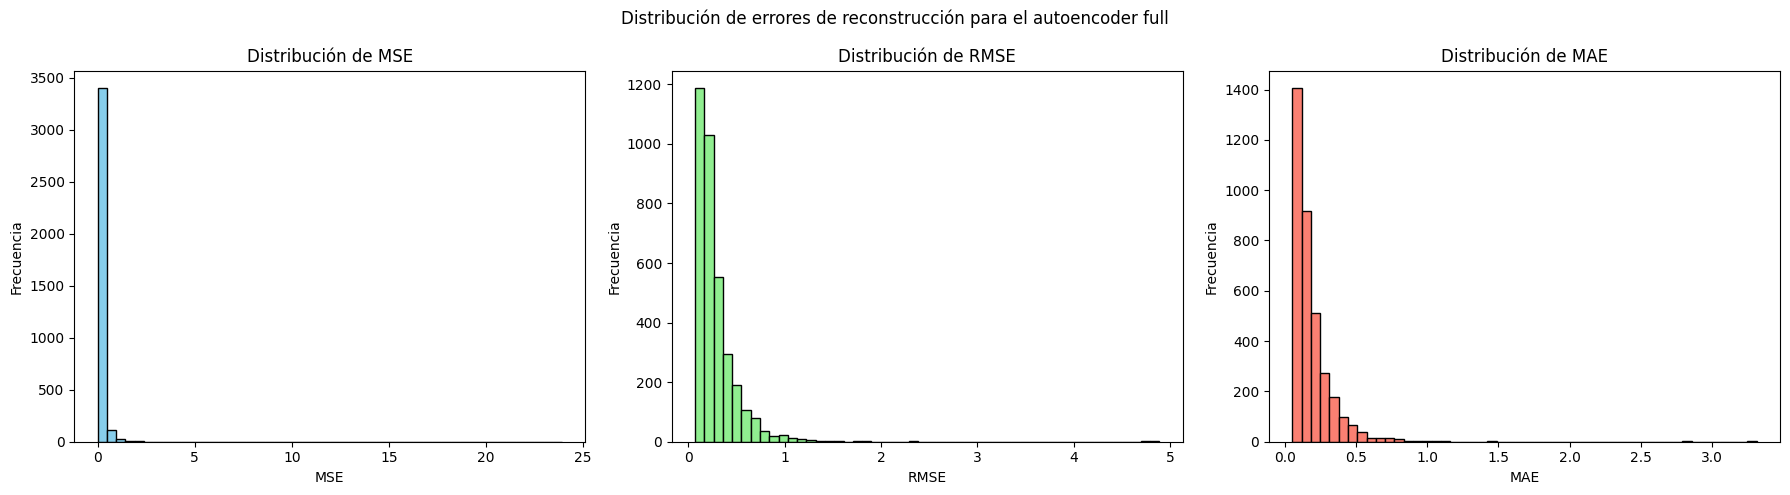

In [34]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el autoencoder full')
plt.subplot(1, 3, 1)
plt.hist(mse_full_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_full_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_full_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Se puede observar que para las tres distribuciones (MSE, RMSE, MAE), la mayoría de muestras tienen errores bajos, y solamente unas pocas tienen errores altos, lo que nos indica que son posibles outliers o ejemplos difíciles de reconstruir.

🟦 Distribución por MSE:
- Se ve un pico pronunciado cerca del 0, es decir, la mayoría de entradas se han reconstruído correctamente
- Tenemos unos cuantos ejemplos con MSE > 1 y algunos extremos que podrían ser anomalías o errores en la reconstrucción

🟩 Distribución de RMSE:
- Muy parecida al MSE
- La mayoría está por debajo de 0.5, lo que es un buen signo

🟥 Distribución de MAE:
- La mayoría de errores son bajos (0 - 0.2)
- Es menos sensible a errores extremos, pero también hay algunos ejemplos con MAE > 2

In [14]:
umbral_rmse = 1.0
outliers = np.where(rmse_vectors > umbral_rmse)[0]
print(f'{len(outliers)} muestras con RMSE > {umbral_rmse}')

42 muestras con RMSE > 1.0


#### Variational Autoencoder (VAE)

In [15]:
class Sampling(tf.keras.layers.Layer):
    """Clase de muestreo para el VAE"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,), name='encoder_input')
    encoded = Dense(512, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(encoded)
    z_log_var = Dense(latent_dim, name='z_log_var')(encoded)
    z = Sampling(name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    h_decoded = Dense(512, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(h_decoded)
    
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE
    outputs = decoder(encoder(inputs)[2])  # Pasa z (muestreo) a través del decoder
    vae = Model(inputs, outputs, name='vae')

    return vae, encoder, decoder

# Pérdida de Reconstrucción (MSE o Binary Crossentropy)
def reconstruction_loss(x, x_decoded):
    return MeanSquaredError()(x, x_decoded)

# Pérdida KL
def kl_loss(z_mean, z_log_var):
    return -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

# Pérdida total (reconstrucción + KL)
def vae_loss(x, x_decoded, z_mean, z_log_var, beta=0.1):
    r_loss = reconstruction_loss(x, x_decoded)
    k_loss = kl_loss(z_mean, z_log_var)
    return r_loss +  k_loss

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [16]:
vae, vae_encoder, vae_decoder = build_vae(input_dim=X.shape[1], latent_dim=128)

vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

vae.summary()
vae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test), callbacks=[early_stopping])

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │       669,952 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1051)           │       605,211 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,163 (4.86 MB)

 Trainable params: 1,275,163 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4567512645632.0000 - val_loss: 6.1629
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7241 - val_loss: 2.4185
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3235 - val_loss: 2.1416
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9355 - val_loss: 1.7229
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5925 - val_loss: 1.5962
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5398 - val_loss: 1.4804
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3907 - val_loss: 1.4450
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3516 - val_loss: 1.3758
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3406 - val_loss: 1.3790
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3190 - val_loss: 1.3722
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3564 - val_loss: 1.3705
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

In [17]:
vae_full, vae_encoder_full, vae_decoder_full = build_vae(input_dim=X_full.shape[1], latent_dim=128)
vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))
vae_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test), callbacks=[early_stopping])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 598826.1250 - val_loss: 7.5427
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5068 - val_loss: 2.8000
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4055 - val_loss: 1.9984
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8588 - val_loss: 1.9023
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6919 - val_loss: 1.6307
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5430 - val_loss: 1.5987
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4775 - val_loss: 1.4968
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4196 - val_loss: 1.4120
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3766 - val_loss: 1.4531
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2940 - val_loss: 1.4762
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2742 - val_loss: 1.2955
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss

### Evaluación

In [18]:
# Reconstrucción con VAE
decoded_vae_vectors = vae.predict(X_test)
decoded_vae_full_vectors = vae_full.predict(X_full_test)

# MSE
mse_vae = np.mean(np.power(X_test - decoded_vae_vectors, 2), axis=1)
mse_vae_full = np.mean(np.power(X_full_test - decoded_vae_full_vectors, 2), axis=1)

# MAE
mae_vae = np.mean(np.abs(X_test - decoded_vae_vectors), axis=1)
mae_vae_full = np.mean(np.abs(X_full_test - decoded_vae_full_vectors), axis=1)

# RMSE
rmse_vae = np.sqrt(mse_vae)
rmse_vae_full = np.sqrt(mse_vae_full)

print(f"VAE MSE: {mse_vae.mean()} ± {mse_vae.std()}")
print(f"VAE RMSE: {rmse_vae.mean()} ± {rmse_vae.std()}")
print(f"VAE MAE: {mae_vae.mean()} ± {mae_vae.std()} \n")

print(f"VAE MSE full: {mse_vae_full.mean()} ± {mse_vae_full.std()}")
print(f"VAE RMSE full: {rmse_vae_full.mean()} ± {rmse_vae_full.std()}")
print(f"VAE MAE full: {mae_vae_full.mean()} ± {mae_vae_full.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
VAE MSE: 0.9573409557342529 ± 6.529607772827148
VAE RMSE: 0.6932119727134705 ± 0.6905057430267334
VAE MAE: 0.49367642402648926 ± 0.4329024851322174 

VAE MSE full: 0.963325023651123 ± 5.989435195922852
VAE RMSE full: 0.7340286374092102 ± 0.6515573859214783
VAE MAE full: 0.47708332538604736 ± 0.39718863368034363


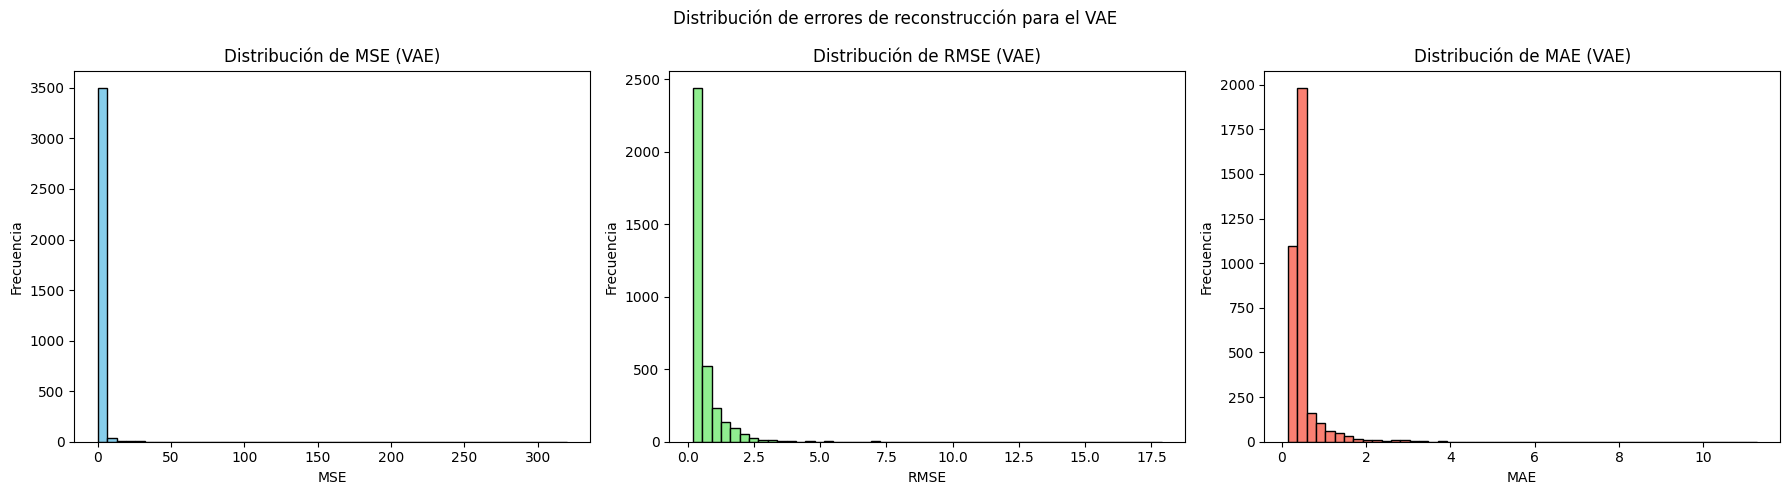

In [36]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el VAE')
plt.subplot(1, 3, 1)
plt.hist(mse_vae, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE (VAE)')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vae, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE (VAE)')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vae, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE (VAE)')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

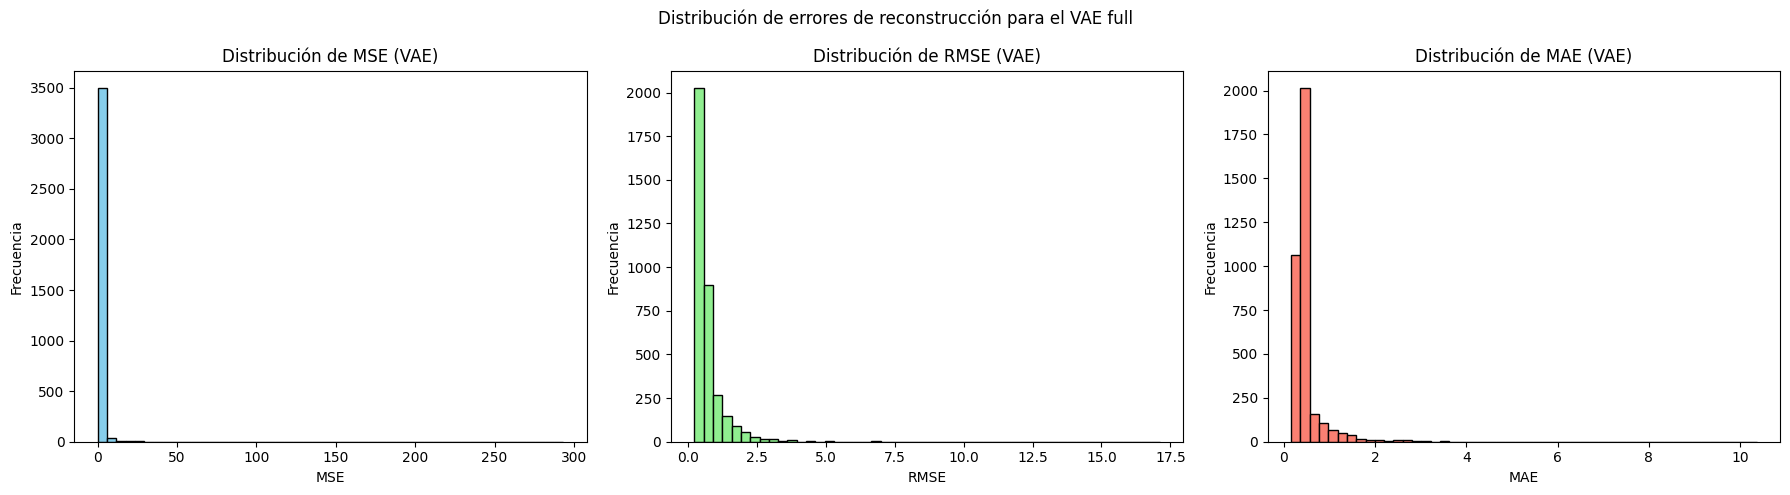

In [37]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el VAE full')
plt.subplot(1, 3, 1)
plt.hist(mse_vae_full, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE (VAE)')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vae_full, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE (VAE)')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vae_full, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE (VAE)')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

A continuación vamos a comparar los errores en los cuatro casos.

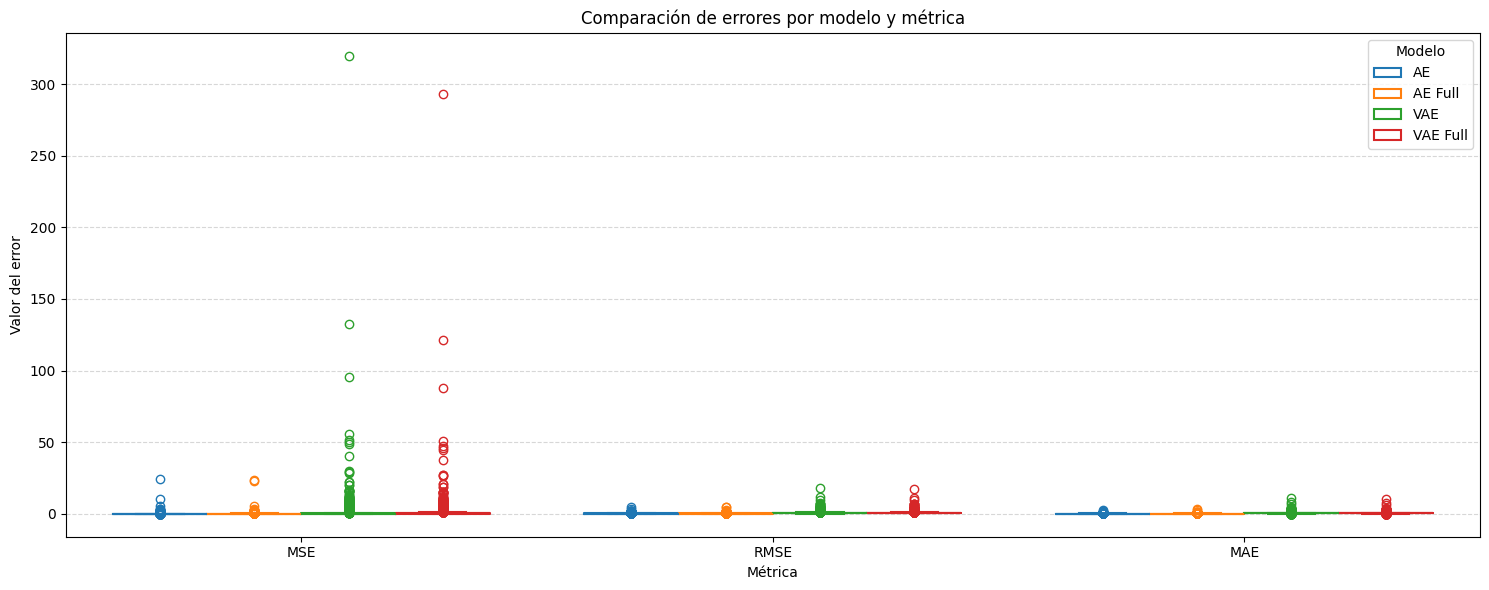

In [56]:
data = {
    'MSE': np.concatenate([mse_vectors, mse_full_vectors, mse_vae, mse_vae_full]),
    'RMSE': np.concatenate([rmse_vectors, rmse_full_vectors, rmse_vae, rmse_vae_full]),
    'MAE': np.concatenate([mae_vectors, mae_full_vectors, mae_vae, mae_vae_full]),
    'Modelo': ['AE'] * len(mse_vectors) + ['AE Full'] * len(mse_full_vectors) + ['VAE'] * len(mse_vae) + ['VAE Full'] * len(mse_vae_full)
}

df_mse = pd.DataFrame({'Error': data['MSE'], 'Métrica': 'MSE', 'Modelo': data['Modelo']})
df_rmse = pd.DataFrame({'Error': data['RMSE'], 'Métrica': 'RMSE', 'Modelo': data['Modelo']})
df_mae = pd.DataFrame({'Error': data['MAE'], 'Métrica': 'MAE', 'Modelo': data['Modelo']})
df_all = pd.concat([df_mse, df_rmse, df_mae], axis=0)

plt.figure(figsize=(15, 6))

sns.boxplot(data=df_all, x='Métrica', y='Error', hue='Modelo', fill=False)
plt.title('Comparación de errores por modelo y métrica')
plt.ylabel('Valor del error')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Entrenamiento final

Entrenamos finalmente nuestros modelos con todo el dataset.

In [85]:
pca.fit(X)
joblib.dump(pca, 'models/pca.pkl')

['models/pca.pkl']

In [87]:
pca_full.fit(X_full)
joblib.dump(pca_full, 'models/pca_full.pkl')

['models/pca_full.pkl']

In [88]:
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)
encoded_vectors = encoder.predict(X)
autoencoder.save("models/autoencoder.keras")
encoder.save("models/encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0910
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0935
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0995
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2240
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1167
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1038
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1207
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0819
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0777
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0751
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0760
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0794
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0700
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0693
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0759
Epoch 16/50
70/70 ━

In [89]:
autoencoder_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
encoded_full_vectors = encoder_full.predict(X_full)
autoencoder_full.save("models/autoencoder_full.keras")
encoder_full.save("models/encoder_full.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1144
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1066
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1335
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1473
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1235
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1109
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1149
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1316
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1059
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1321
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1081
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1228
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1092
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1084
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0996
Epoch 16/50
70/70 ━

In [90]:
vae.fit(X, X, epochs=50, batch_size=256, shuffle=True)
vae_encoded_vectors = vae_encoder.predict(X, batch_size=32)
vae.save("models/vae.keras")
vae_encoder.save("models/vae_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1587
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1276
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0960
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0822
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0722
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0380
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0591
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9937
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0629
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1052
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0832
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0402
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0183
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0254
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9779
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [91]:
vae_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
vae_encoded_full_vectors = vae_encoder_full.predict(X_full, batch_size=32)
vae_full.save("models/vae_full.keras")
vae_encoder_full.save("models/vae_full_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0793
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0516
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9835
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0997
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1083
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0246
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9951
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0180
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0433
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0923
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9959
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0374
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9842
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0105
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0024
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [92]:
df_embeddings = pd.DataFrame({
    'clip_id': features_df['clip_id'].values,
    'original_embeddings': list(vectors),
    'encoded_embeddings': list(encoded_vectors),
    'original_full_embeddings': list(full_vectors),
    'encoded_full_embeddings': list(encoded_full_vectors),
    'vae_embeddings': list(vae_encoded_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
    'vae_full_embeddings': list(vae_encoded_full_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
})
df_embeddings.to_sql('embeddings', sqlite3.connect('dataset/embeddings.db'), if_exists='replace', index=False)

17783

In [93]:
def get_genres():
    """Obtiene los géneros de la base de datos"""
    conn = sqlite3.connect("dataset/genres.db")
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()
    genres_df.drop(columns=['mp3_path'], inplace=True)

    genres_df = genres_df.melt(id_vars=['clip_id'], var_name='genre', value_name='value')
    genres_df = genres_df[genres_df['value'] == 1]
    genres_df = genres_df.drop(columns=['value'])

    genres_df = genres_df.groupby('clip_id')['genre'].apply(lambda x: list(x)).reset_index()
    genres_df.rename(columns={'genre': 'genres'}, inplace=True)
    genres_df['genres'] = genres_df['genres'].apply(lambda x: ', '.join(x))
    return genres_df


genres_df = get_genres()

all_genres = set()
for genre_str in genres_df['genres']:
    genres = [g.strip().lower() for g in genre_str.split(',')]
    all_genres.update(genres)

# Mapear géneros a posiciones lineales en [0, 1] y aplicar viridis
sorted_genres = sorted(all_genres)
genre_to_value = {genre: i / (len(sorted_genres) - 1) for i, genre in enumerate(sorted_genres)}
cmap = plt.get_cmap('gist_rainbow')
genre_colors = {genre: cmap(genre_to_value[genre]) for genre in sorted_genres}

def blend_colors(genre_list):
    colors = [np.array(genre_colors[g]) for g in genre_list if g in genre_colors]
    avg_color = np.mean(colors, axis=0)
    return tuple(avg_color)

# Asignar color mezclado a cada canción
clip_colors = []
for genre_str in genres_df['genres']:
    genres = [g.strip().lower() for g in genre_str.split(',')]
    mixed_color = blend_colors(genres)
    clip_colors.append(mixed_color)

In [94]:
# Visualización del espacio latente del autoencoder y el variational autoencoder
def plot_latent_space(latent_space_1, latent_space_2, title):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(latent_space_1[:, 0], latent_space_1[:, 1], alpha=0.5, c=clip_colors)
    plt.title('Espacio Latente del Autoencoder')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(latent_space_2[:, 0], latent_space_2[:, 1], alpha=0.5, c=clip_colors)
    plt.title('Espacio Latente del VAE')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

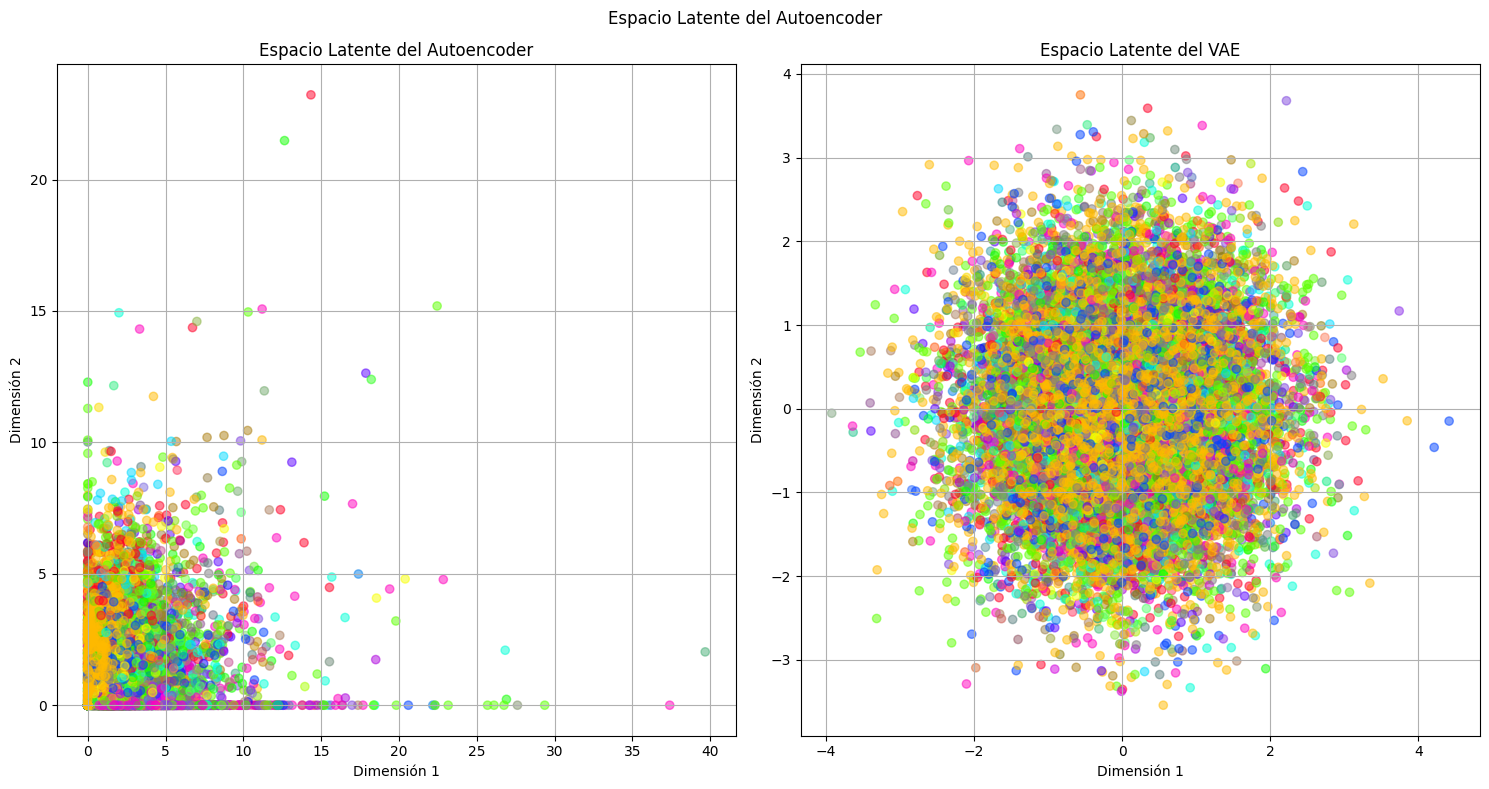

In [95]:
plot_latent_space(encoded_vectors, vae_encoded_vectors[2] ,'Espacio Latente del Autoencoder')